In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
input_length = 168
output_length = 24

show_graph = True

In [2]:
# Original Group

# model_paths = ["Save_File/Grouped_model_0601/A1.ckpt",
#                 "Save_File/Grouped_model_0601/A2.ckpt",
#                 "Save_File/Grouped_model_0601/A3.ckpt",
#                 "Save_File/Grouped_model_0601/A4.ckpt",
#                 "Save_File/Grouped_model_0601/B1.ckpt",
#                 "Save_File/Grouped_model_0601/B2.ckpt",
#                 "Save_File/Grouped_model_0601/B3.ckpt",
#                 "Save_File/Grouped_model_0601/B4.ckpt",
#                 "Save_File/Grouped_model_0601/C1.ckpt",
#                 "Save_File/Grouped_model_0601/C2.ckpt",
#                 "Save_File/Grouped_model_0601/C3.ckpt",
#                 "Save_File/Grouped_model_0601/C4.ckpt",
#                 "Save_File/Grouped_model_0601/D1.ckpt",
#                 "Save_File/Grouped_model_0601/D2.ckpt",
#                 "Save_File/Grouped_model_0601/D3.ckpt",
#                 "Save_File/Grouped_model_0601/D4.ckpt",
#                 "Save_File/Grouped_model_0601/D5.ckpt",
#                 "Save_File/Grouped_model_0601/E1.ckpt",
#                 "Save_File/Grouped_model_0601/E2.ckpt",
#                 "Save_File/Grouped_model_0601/E3.ckpt",
#                 "Save_File/Grouped_model_0601/E4.ckpt"]

# group_name = [
#     "A1", "A2", "A3", "A4", 
#     "B1", "B2", "B3", "B4",
#     "C1", "C2", "C3", "C4", 
#     "D1", "D2", "D3", "D4", "D5", 
#     "E1", "E2", "E3", "E4"
# ]

# group = [
#     [4],[10, 11, 12, 41],[34],[40, 42]
#     ,[6, 8, 13, 17, 25, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47]
#     ,[1, 31],[9, 32],[3],[33]
#     ,[2, 14, 22, 23, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45]
#     ,[5, 59],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60]
# ]

# data_path = "./Refined_Data/Grouped_Data/Input_Data.csv"

# Group 2

model_paths = ["Save_File/Grouped2_model_0602/A1.ckpt",
                "Save_File/Grouped2_model_0602/A2.ckpt",
                "Save_File/Grouped2_model_0602/A3.ckpt",
                "Save_File/Grouped2_model_0602/A4.ckpt",
                "Save_File/Grouped2_model_0602/A5.ckpt",
                "Save_File/Grouped2_model_0602/A6.ckpt",
                "Save_File/Grouped2_model_0602/A7.ckpt",
                "Save_File/Grouped2_model_0602/B1.ckpt",
                "Save_File/Grouped2_model_0602/B2.ckpt",
                "Save_File/Grouped2_model_0602/B3.ckpt",
                "Save_File/Grouped2_model_0602/B4.ckpt",
                "Save_File/Grouped2_model_0602/B5.ckpt",
                "Save_File/Grouped2_model_0602/C1.ckpt",
                "Save_File/Grouped2_model_0602/C2.ckpt",
                "Save_File/Grouped2_model_0602/C3.ckpt",
                "Save_File/Grouped2_model_0602/C4.ckpt",
                "Save_File/Grouped2_model_0602/D1.ckpt",
                "Save_File/Grouped2_model_0602/D2.ckpt",
                "Save_File/Grouped2_model_0602/D3.ckpt",
                "Save_File/Grouped2_model_0602/D4.ckpt",
                "Save_File/Grouped2_model_0602/D5.ckpt",
                "Save_File/Grouped2_model_0602/D6.ckpt",
                "Save_File/Grouped2_model_0602/E1.ckpt",
                "Save_File/Grouped2_model_0602/E2.ckpt",
                "Save_File/Grouped2_model_0602/E3.ckpt",
                "Save_File/Grouped2_model_0602/E4.ckpt",
                "Save_File/Grouped2_model_0602/E5.ckpt"]

group_name = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", 
    "D1", "D2", "D3", "D4", "D5", "D6", 
    "E1", "E2", "E3", "E4", "E5"
]

group = [
    [4],[11, 12],[34],[40],[10],[42],[41]
    ,[6, 8, 13, 17, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47],[25]
    ,[1, 31],[9, 32],[3],[33]
    ,[2, 14, 22, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45],[23]
    ,[5],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60],[59]
]

data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"

In [3]:
dataframes = pd.read_csv(data_path, parse_dates = ["date_time"])

dataframes['num']     =   dataframes['num'].apply(str)
dataframes['Week']    =   dataframes['Week'].apply(str)
dataframes['24Hour']  =   dataframes['24Hour'].apply(str)
dataframes['holiday'] =   dataframes['holiday'].apply(str)
dataframes['Weekend'] =   dataframes['Weekend'].apply(str)
dataframes['energy_group'] = dataframes['energy_group'].apply(str)

random_choice = random.randrange(2,13)

start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

all_smape = []
part_smape = [[] for i in range(len(group_name))]

now group : A1


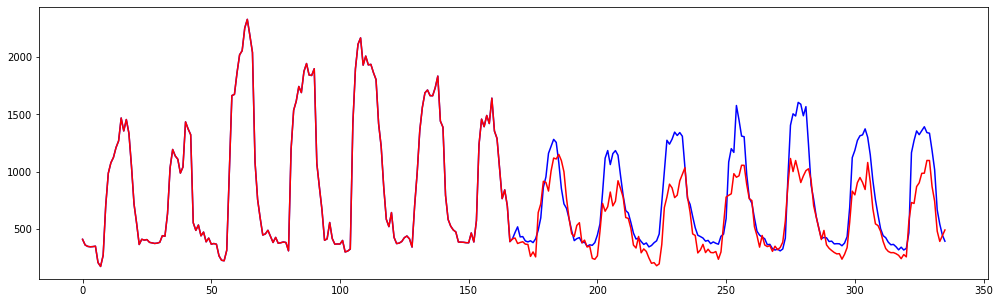

building : 4, score : 24.42501990496087
now group : A2


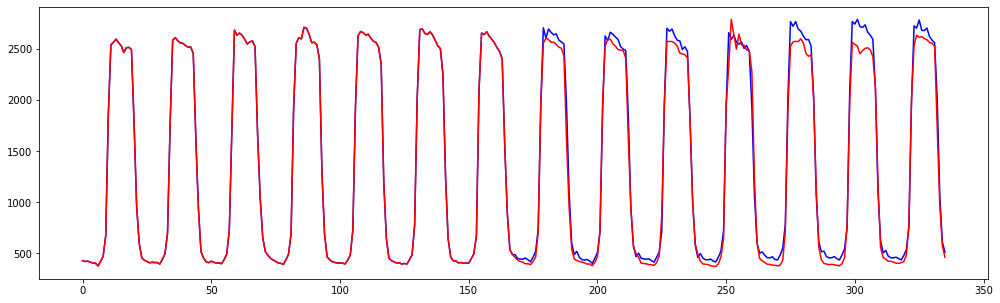

building : 10, score : 8.041459255202724


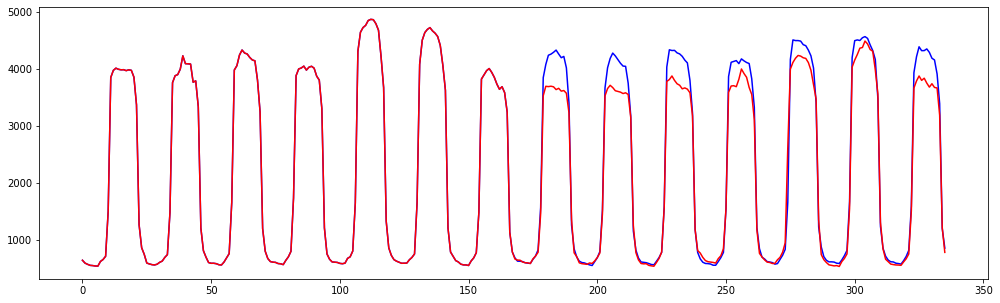

building : 11, score : 7.129691533589494


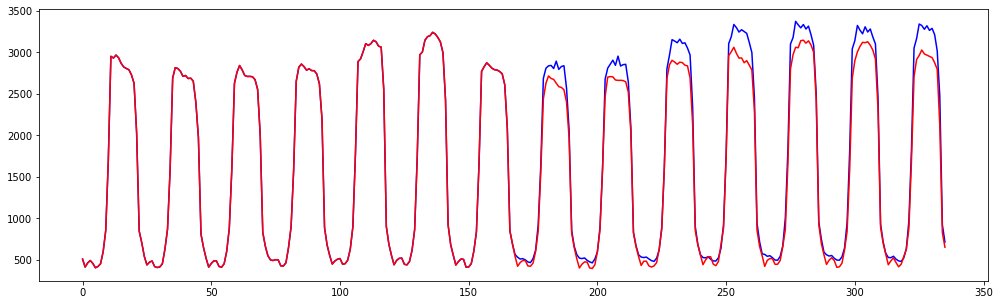

building : 12, score : 8.117918098177999


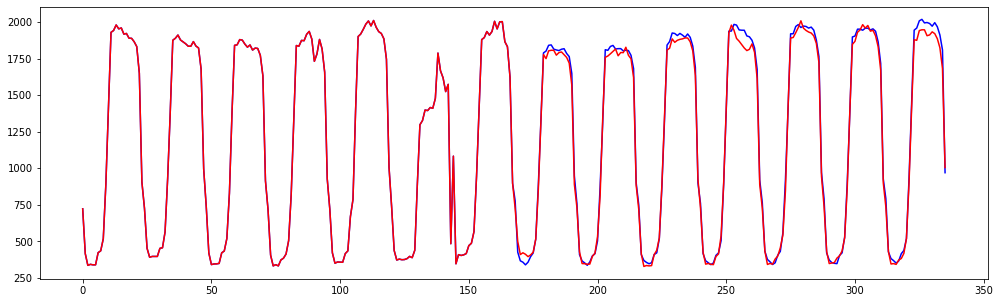

building : 41, score : 3.255593782286283
now group : A3


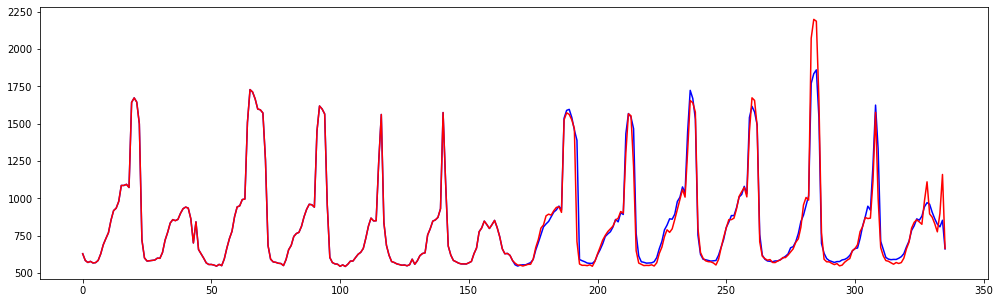

building : 34, score : 4.326004018706284
now group : A4


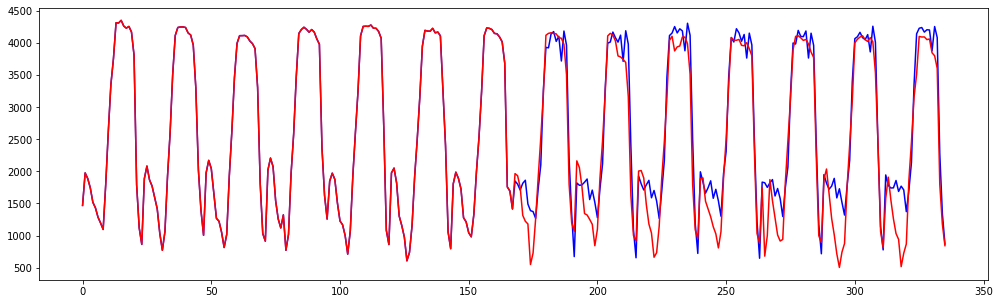

building : 40, score : 18.182934742388227


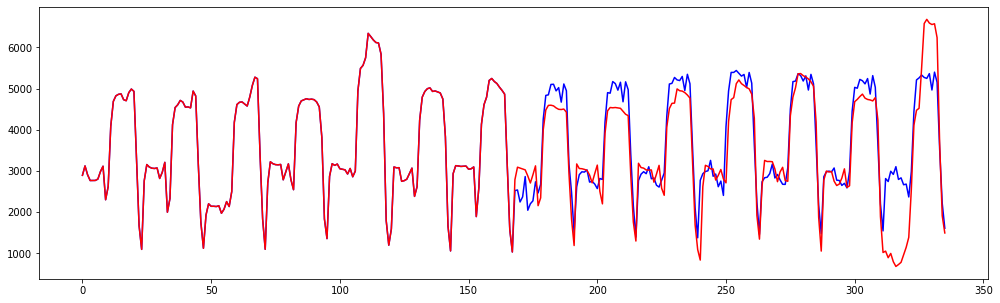

building : 42, score : 16.35686762744489
now group : B1


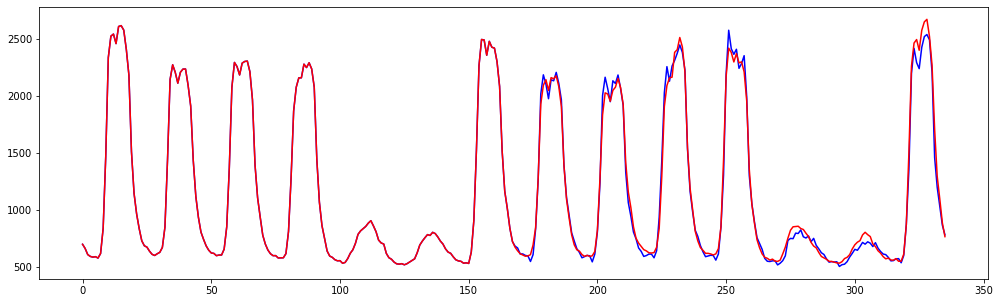

building : 6, score : 4.151637826036988


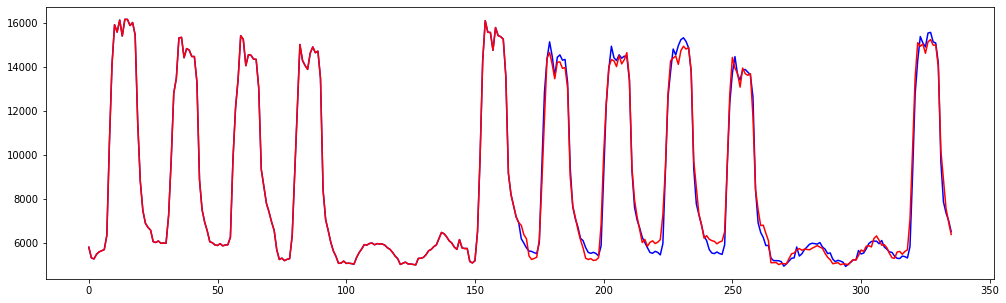

building : 8, score : 3.778416565246104


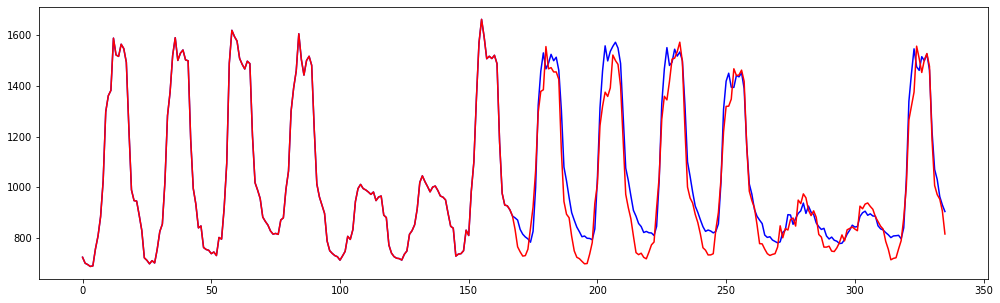

building : 13, score : 6.03943870103794


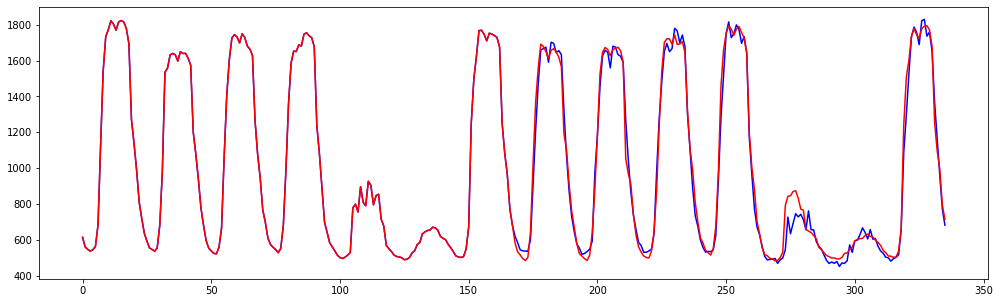

building : 17, score : 4.852141649222799


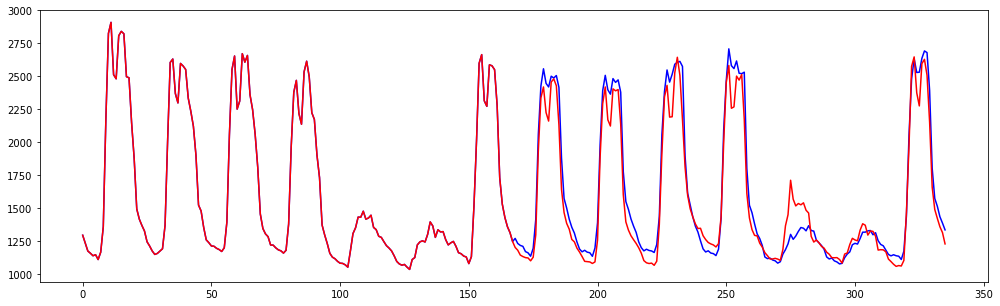

building : 25, score : 5.735934733066679


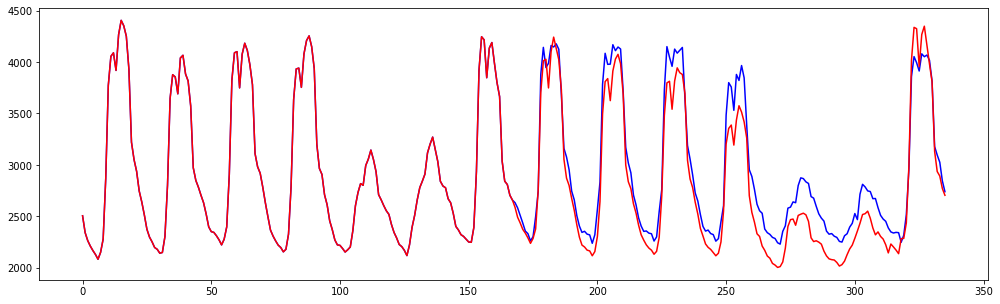

building : 26, score : 6.881200639277328


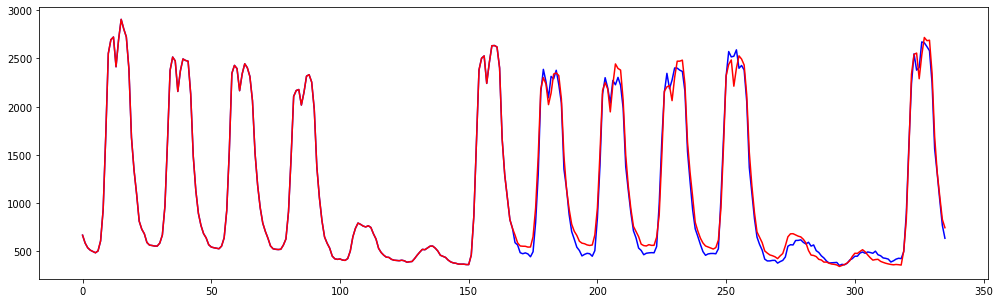

building : 48, score : 9.313943596338989


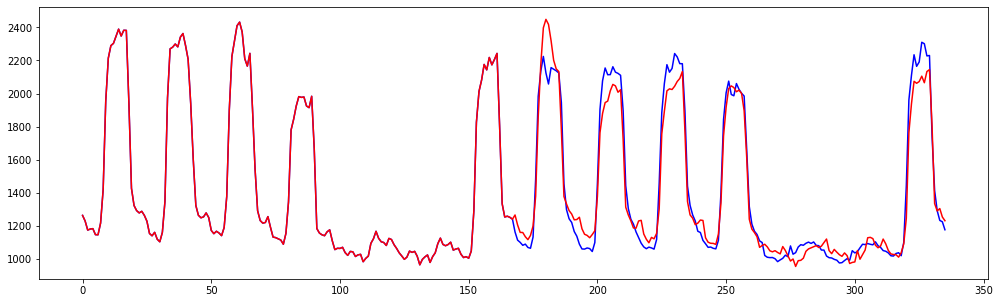

building : 53, score : 5.047923185425636


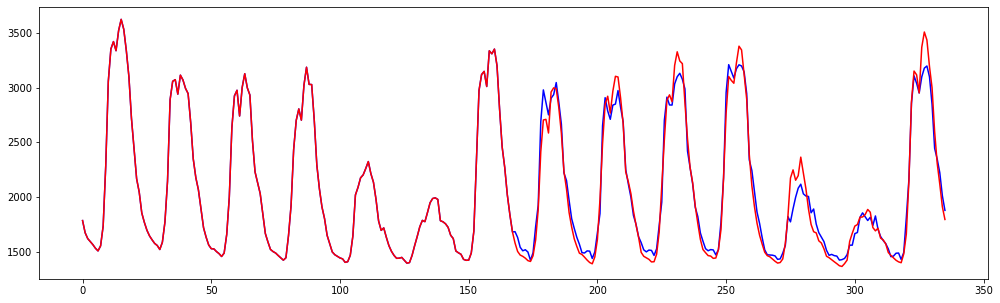

building : 55, score : 3.9586035811912303


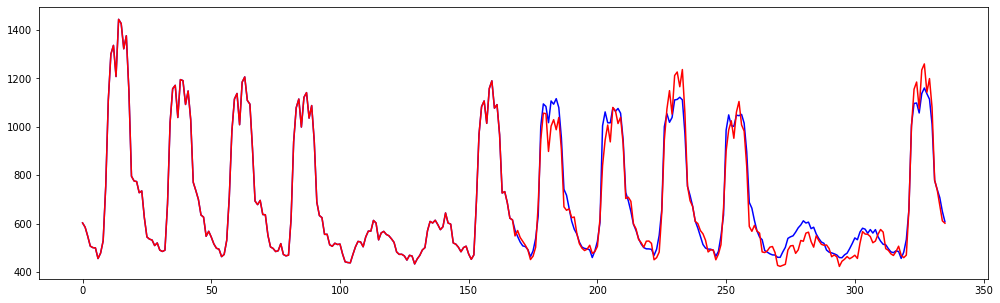

building : 56, score : 5.214710545084245
now group : B2


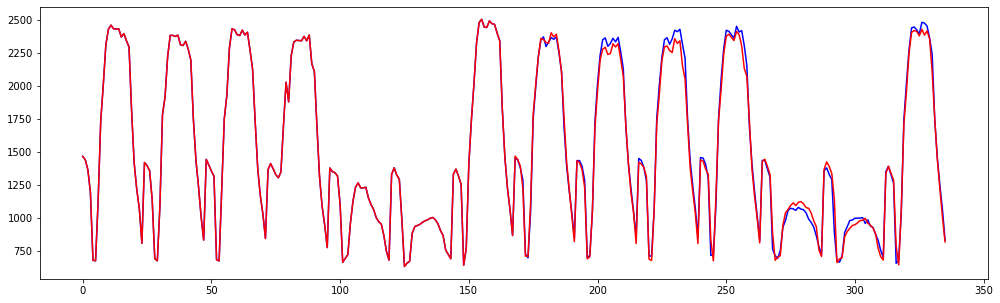

building : 7, score : 2.988117038878985


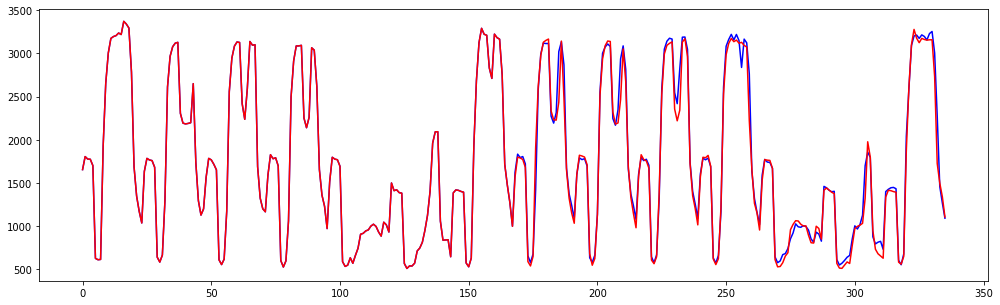

building : 18, score : 4.749586561232857
now group : B3


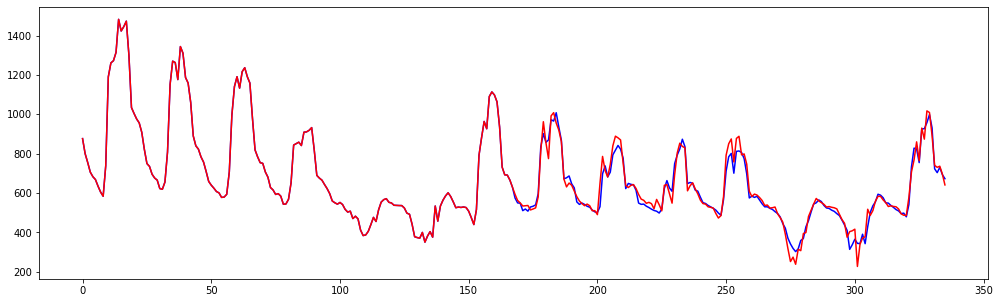

building : 27, score : 4.515363585729586


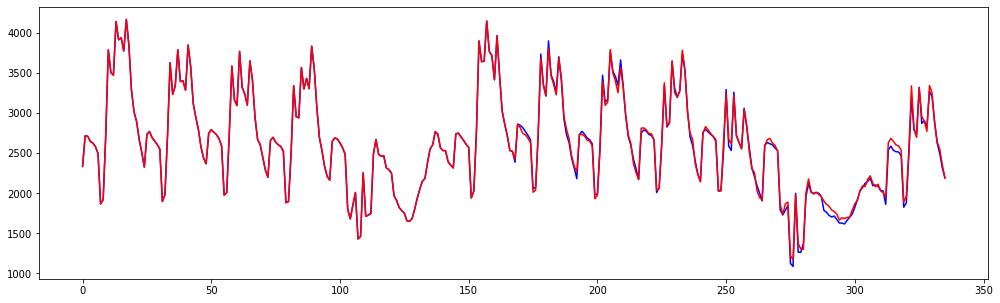

building : 57, score : 1.737878628406427
now group : B4


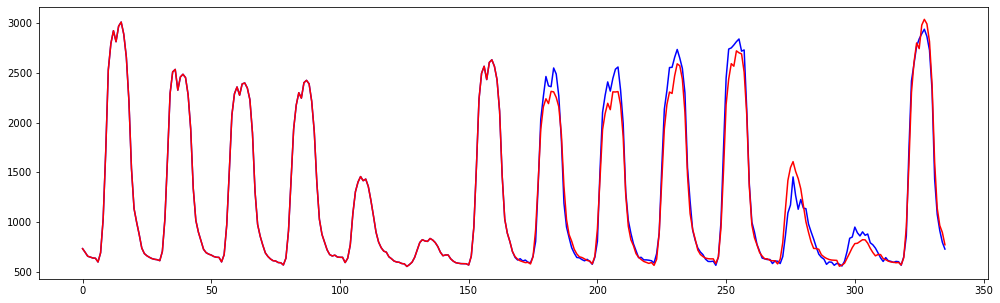

building : 35, score : 6.164747679020237


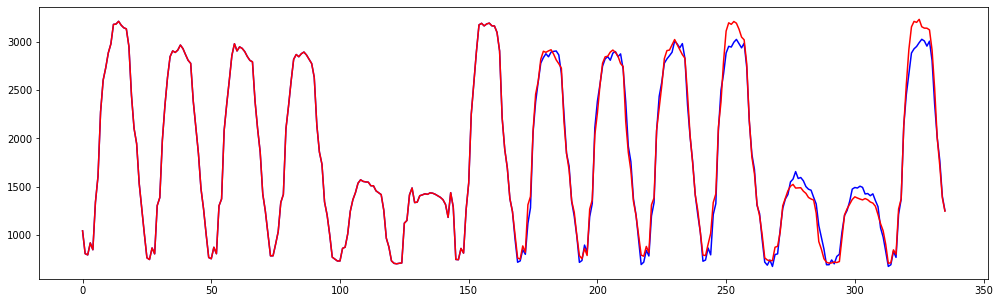

building : 46, score : 4.396155579901535


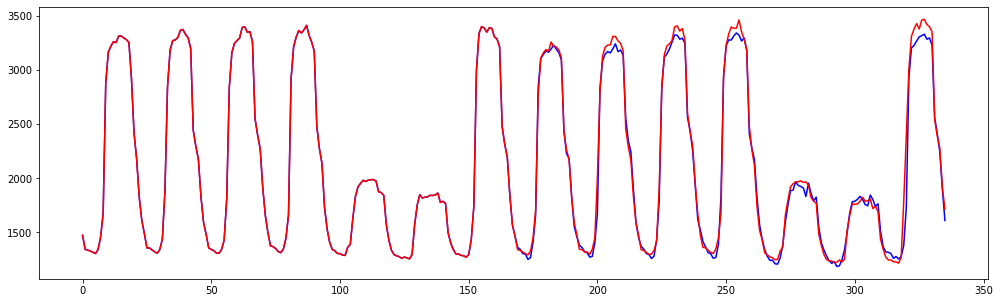

building : 47, score : 2.68859427132834
now group : C1


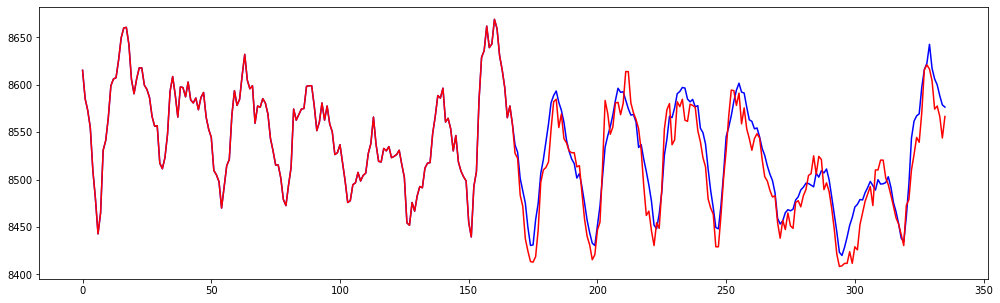

building : 1, score : 0.19742390929214174


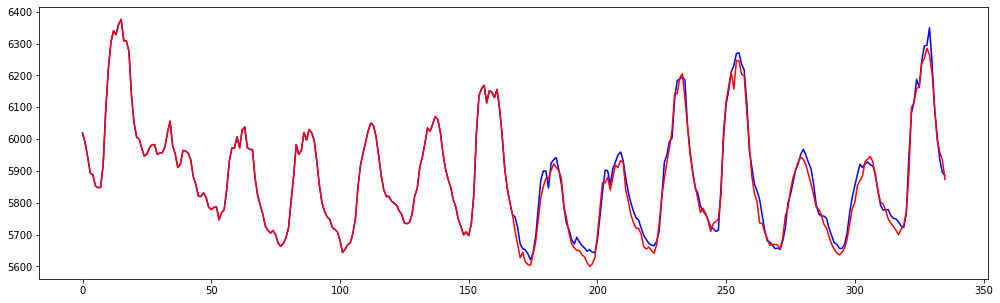

building : 31, score : 0.39081456322877955
now group : C2


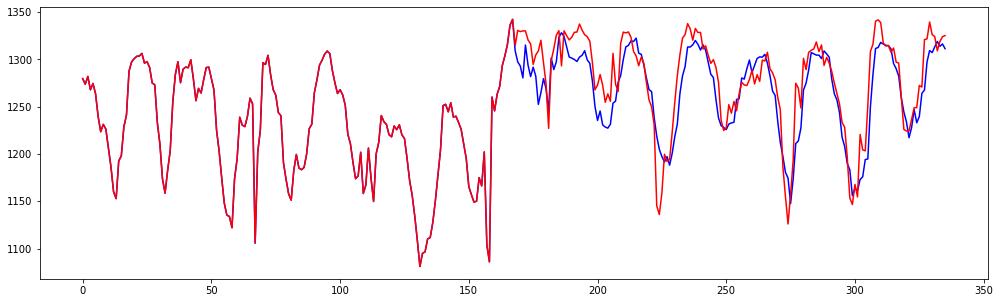

building : 9, score : 1.561066546793855


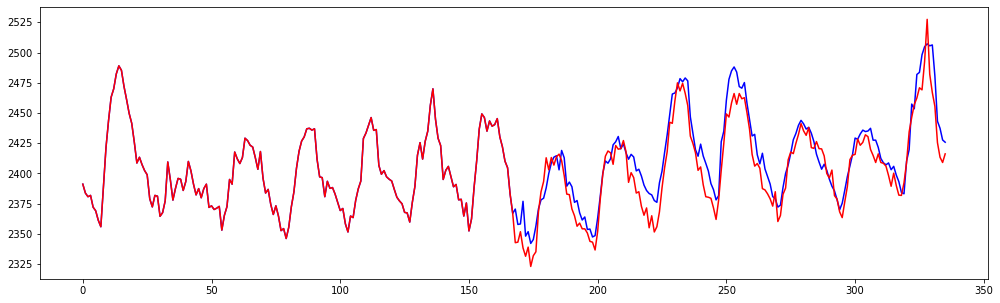

building : 32, score : 0.4967766282239405
now group : C3


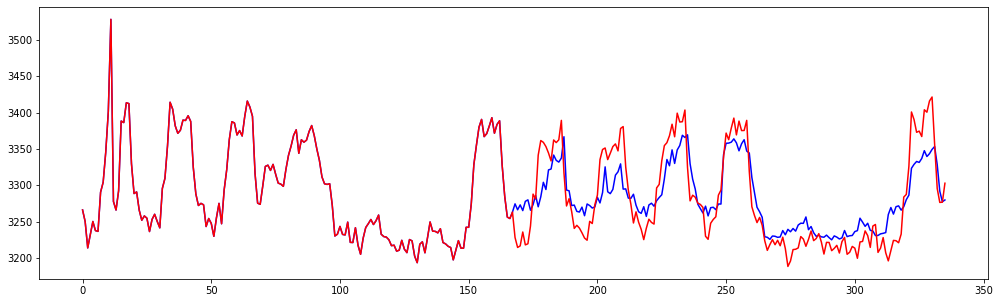

building : 3, score : 0.8471636359277888
now group : C4


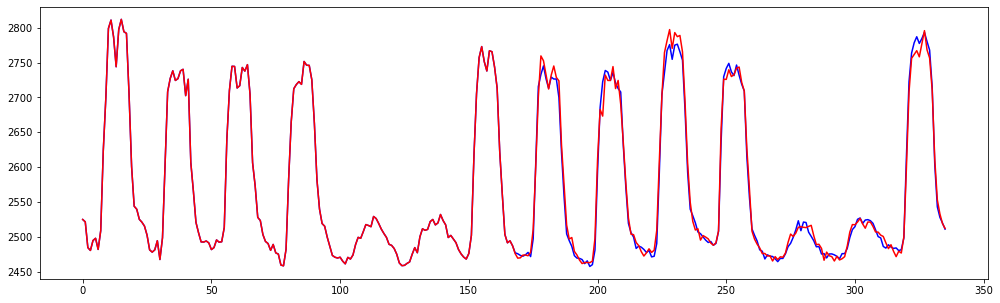

building : 33, score : 0.292880700857768
now group : D1


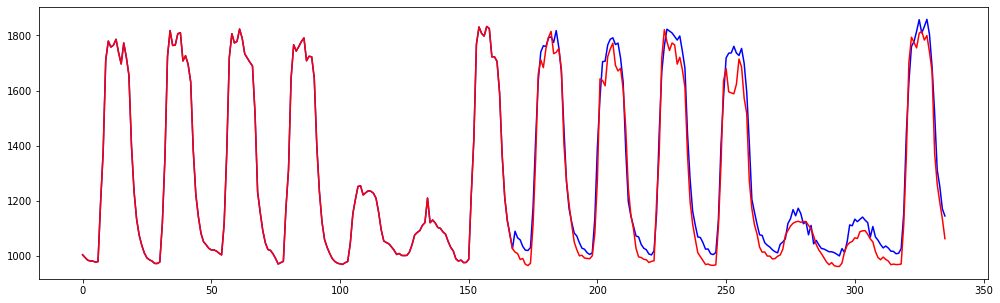

building : 2, score : 3.806480815489144


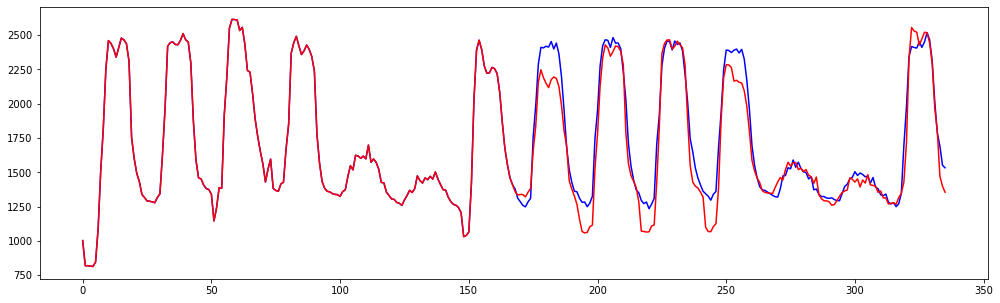

building : 14, score : 5.743754743550182


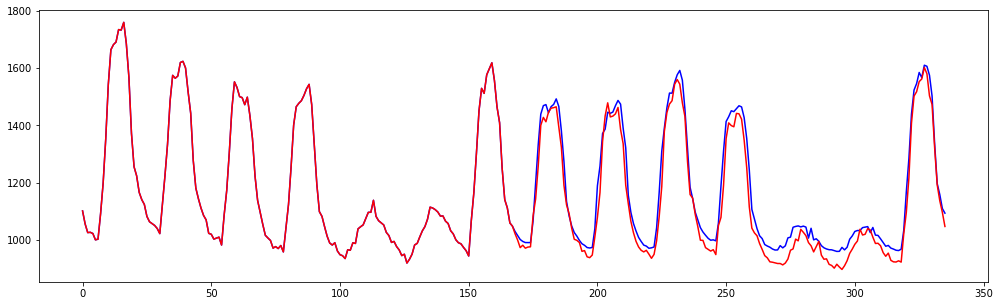

building : 22, score : 3.4616593436263927


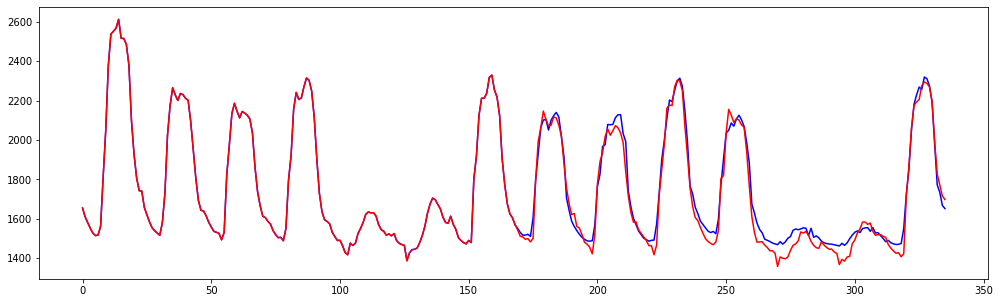

building : 23, score : 2.4000308984707166


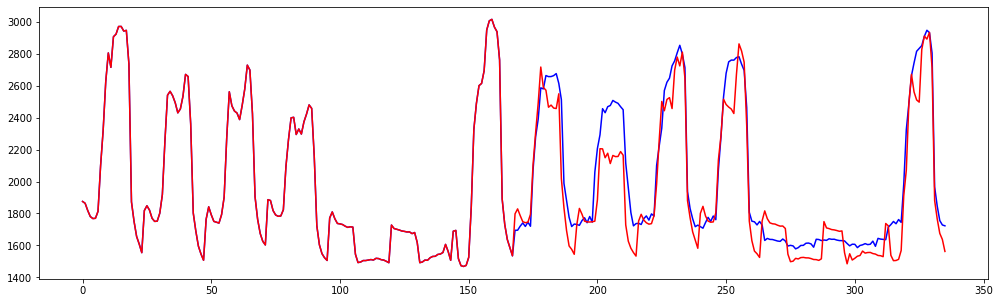

building : 37, score : 5.980737210153827


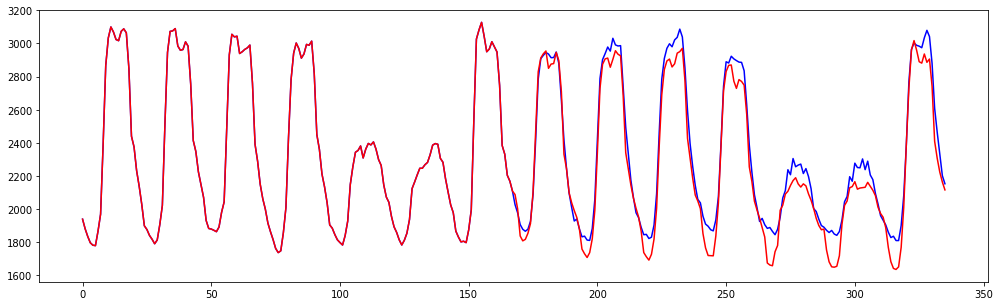

building : 44, score : 3.65467091473584


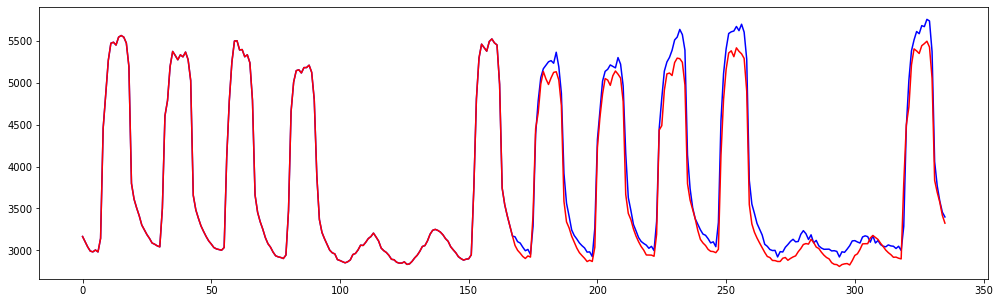

building : 52, score : 3.938791617463389


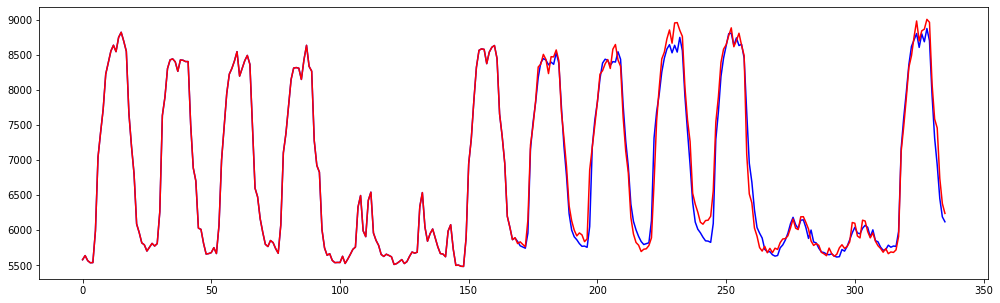

building : 54, score : 1.7796406458915173
now group : D2


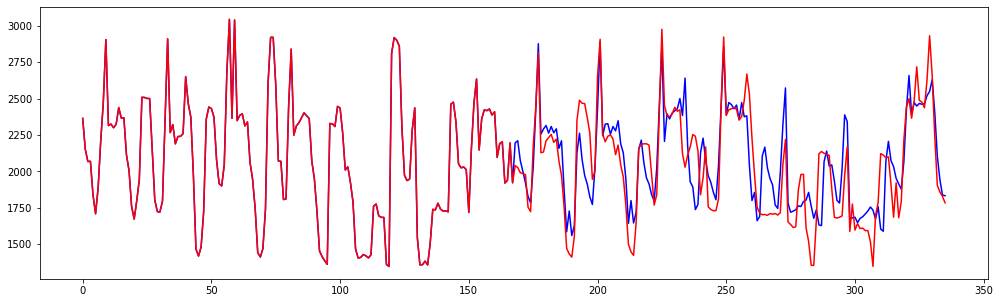

building : 15, score : 8.186490491698962
now group : D3


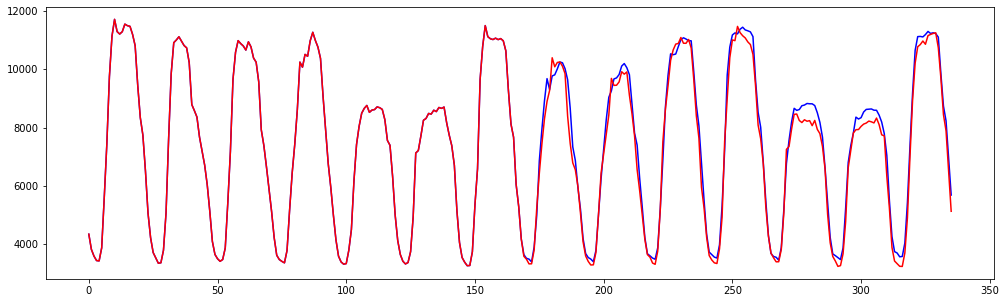

building : 38, score : 4.177788122342187


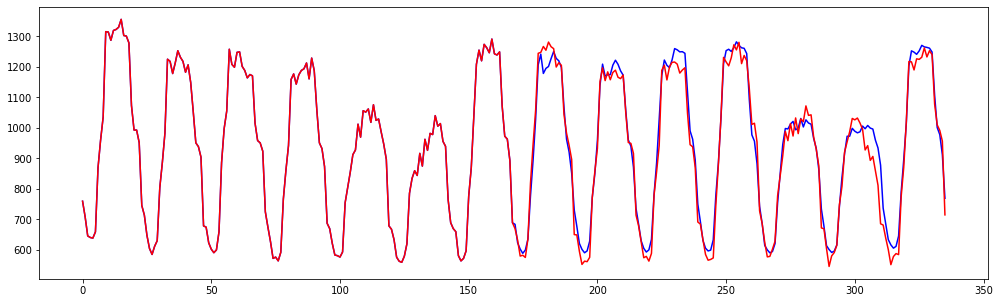

building : 58, score : 3.472839796241905


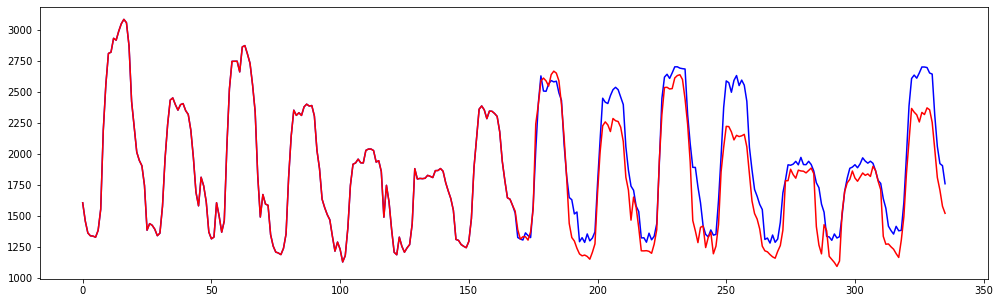

building : 43, score : 9.138170904931169
now group : D4


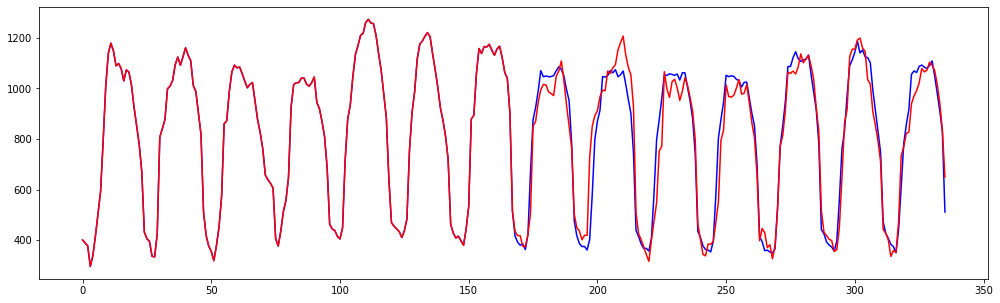

building : 29, score : 7.03622188284811


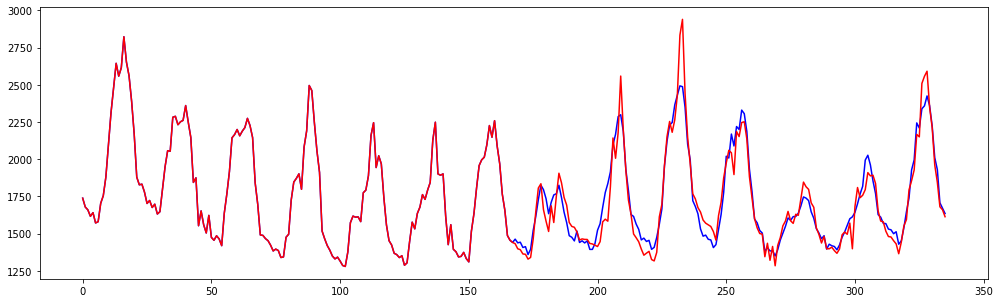

building : 39, score : 3.7807181573880553
now group : D5


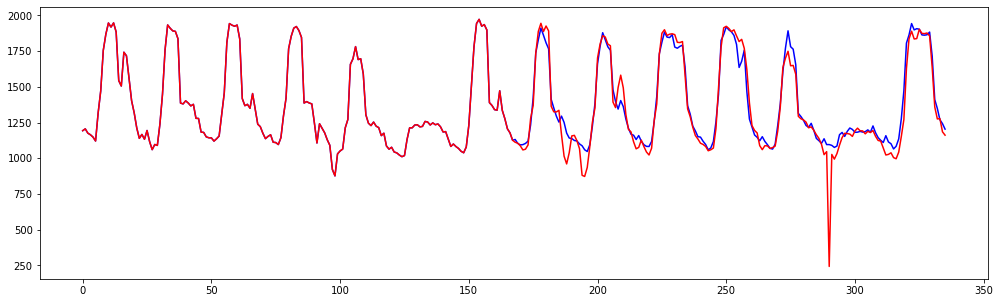

building : 45, score : 4.521315109870231
now group : E1


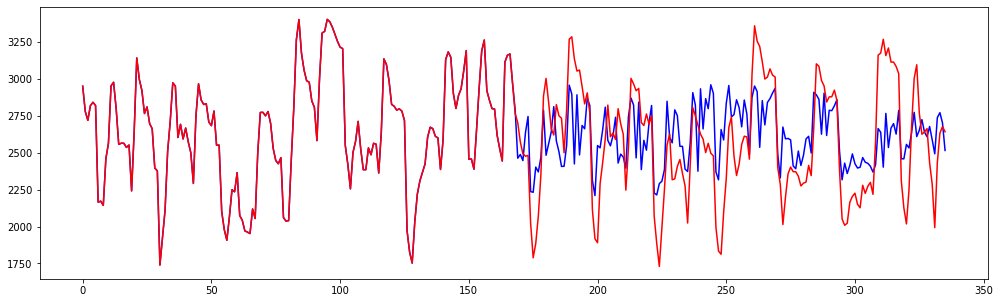

building : 5, score : 9.861025457300872


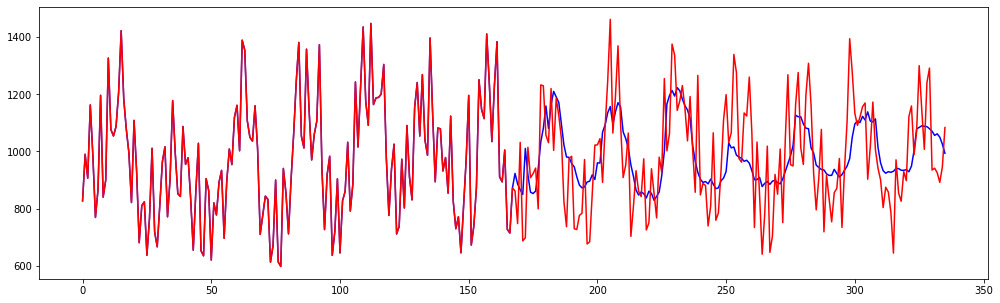

building : 59, score : 11.901561997241242
now group : E2


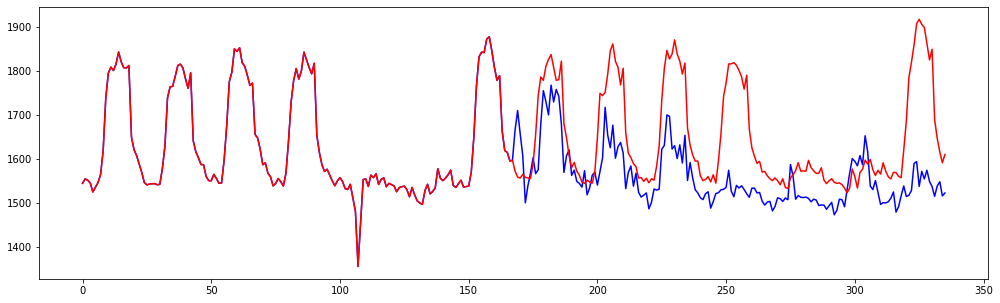

building : 16, score : 6.003729381318039


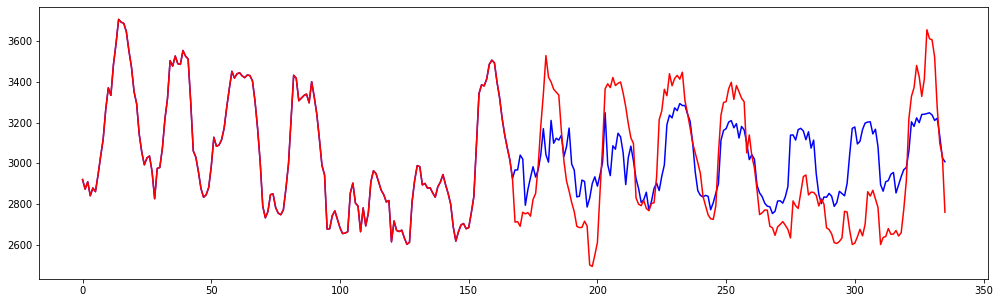

building : 24, score : 6.396888596306186
now group : E3


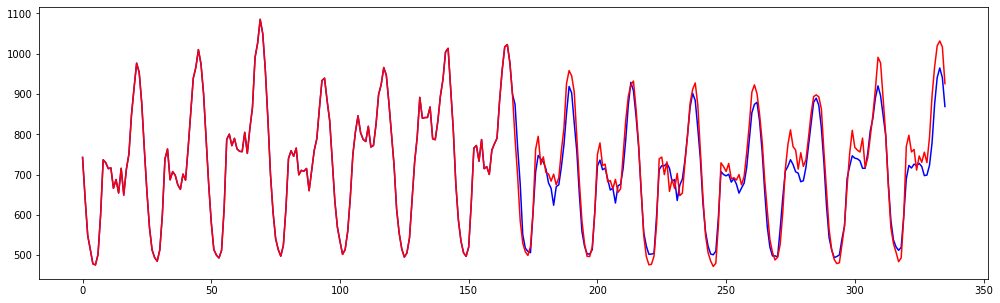

building : 19, score : 3.9714684598774954


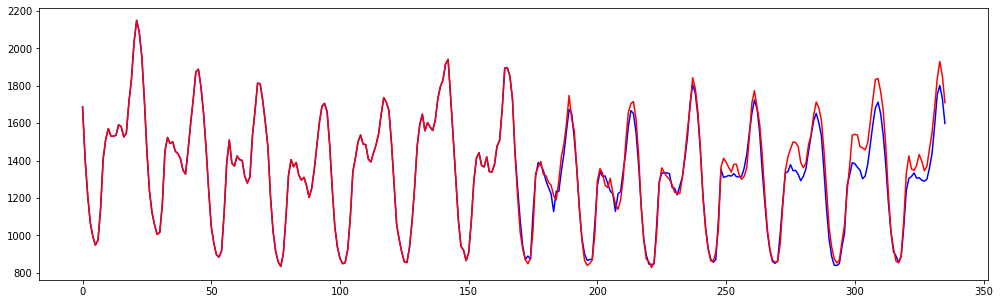

building : 20, score : 3.7305682882839


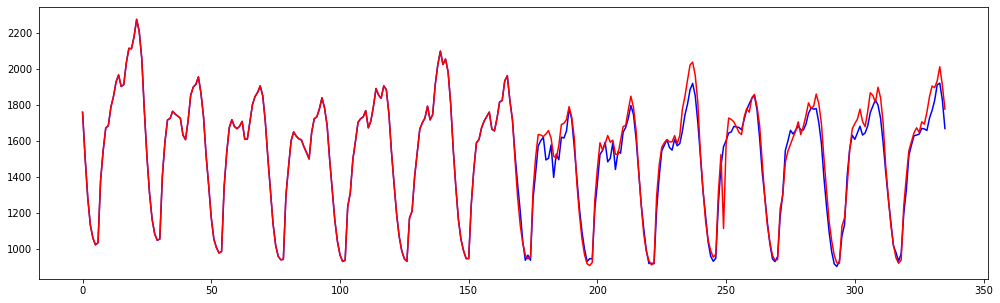

building : 21, score : 3.31583579943352


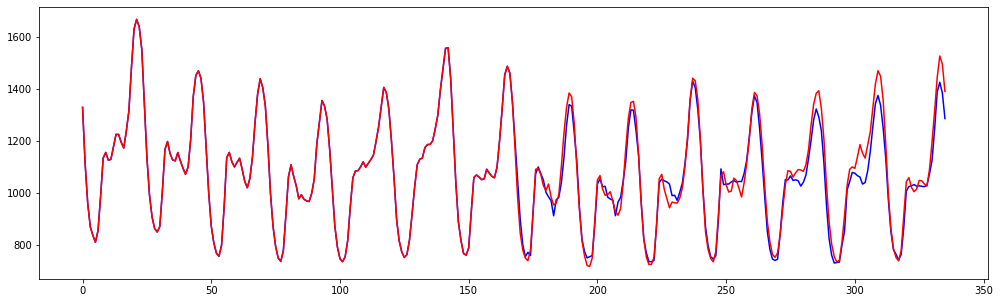

building : 49, score : 3.12426650986814


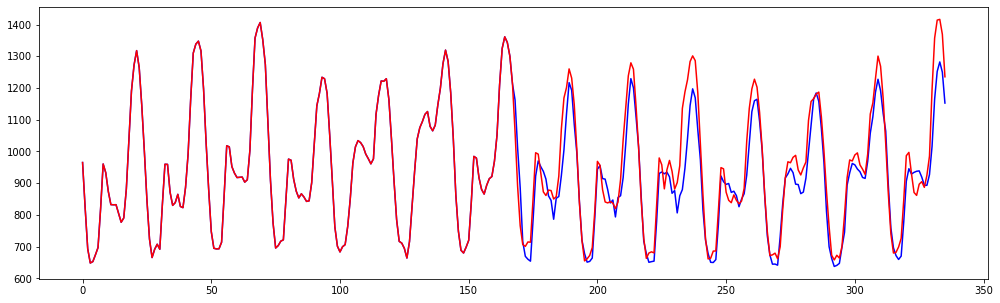

building : 50, score : 5.13038124278067


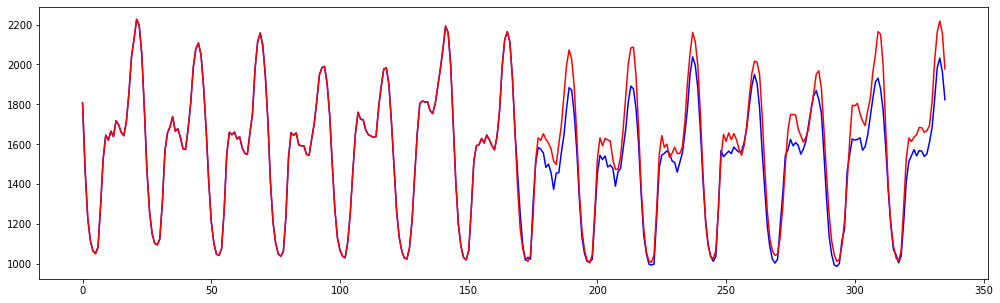

building : 51, score : 5.03731668893553
now group : E4


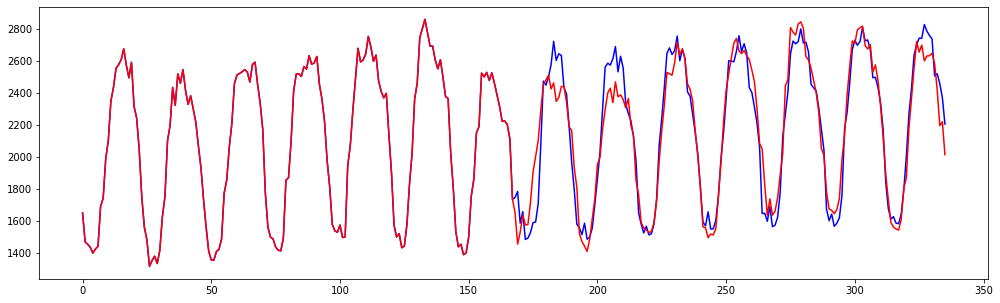

building : 28, score : 4.406945433769686


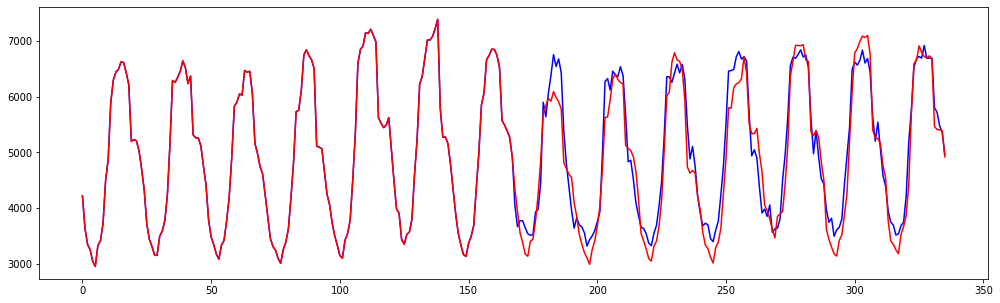

building : 30, score : 6.254320033877321


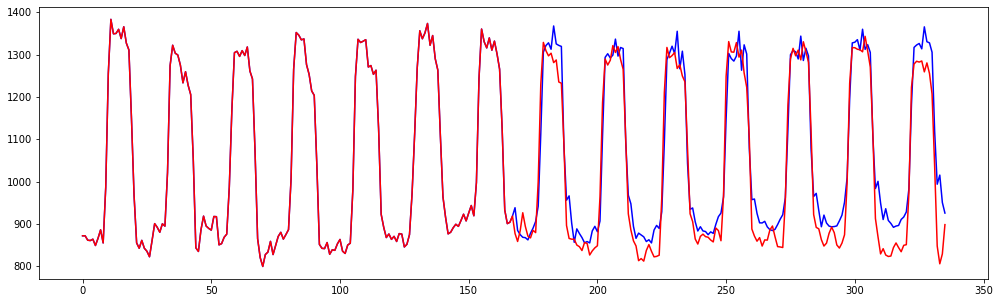

building : 36, score : 4.312781851469349


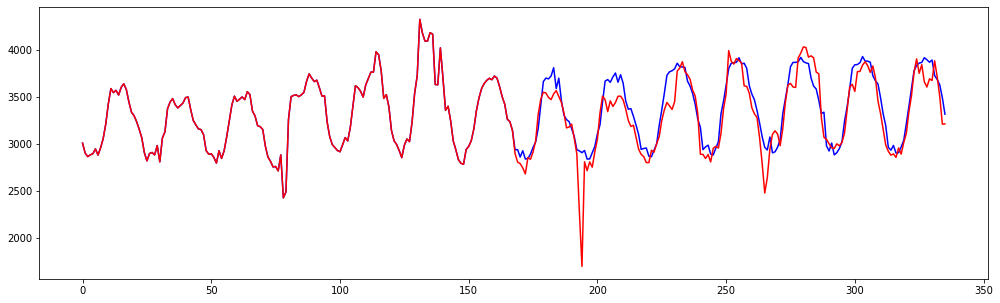

building : 60, score : 4.094169939377764


In [4]:
for i in range(len(model_paths)):
    now_dataframe = dataframes.loc[dataframes["energy_group"] == str(i)].copy()
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    print(f"now group : {group_name[i]}")

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]

        original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (17,5)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.plot(prediction, color='blue')
            graph.plot(original, color='red')
            plt.show()

        smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
        print(f"building : {building}, score : {smape_loss}")
        all_smape.append(smape_loss)
        part_smape[i].append(smape_loss)

        # break
    # break

In [5]:
print("\n")
print(f"selected time slice : {random_choice}")
print(f"totoal score : {np.mean(np.array(all_smape))}")
for i in range(len(group_name)):
    print(f"{group_name[i]} score : {np.mean(np.array(part_smape[i]))}")



selected time slice : 9
totoal score : 5.407609660800805
A1 score : 24.42501990496087
A2 score : 6.636165667314125
A3 score : 4.326004018706284
A4 score : 17.269901184916556
B1 score : 5.497395102192793
B2 score : 3.8688518000559213
B3 score : 3.1266211070680066
B4 score : 4.416499176750038
C1 score : 0.29411923626046066
C2 score : 1.0289215875088977
C3 score : 0.8471636359277888
C4 score : 0.292880700857768
D1 score : 3.845720773672626
D2 score : 8.186490491698962
D3 score : 5.596266274505087
D4 score : 5.408470020118083
D5 score : 4.521315109870231
E1 score : 10.881293727271057
E2 score : 6.200308988812113
E3 score : 4.0516394981965425
E4 score : 4.76705431462353
